# Lab1 Logistic Regression using a Neural Network
## Логістична регресія за допомогою нейронної мережі

Ми використовуватимемо нейронні мережі для побудови класифікатора логістичної регресії для розпізнавання зображень.

Під час вправ вам потрібно буде заповнити код між цими коментарями:
```python
# CODE_START
<...your code here...>
# CODE_END
```

Будь ласка, пам’ятайте, що нам потрібно векторизувати наш код, тому:

    Не використовуйте цикли (for/while) у коді, якщо в інструкціях явно не вказано це зробити.

    Використовуйте np.dot(X, Y) для обчислення скалярних добутків.

Під час вправ ви:

    Побудуєте загальну архітектуру алгоритму навчання, включаючи:

        Ініціалізацію параметрів

        Обчислення функції вартості та її градієнта

        Використання алгоритму оптимізації (градієнтний спуск)

    Об’єднаєте всі три функції вище в основну функцію моделі у правильному порядку.

<a name='1'></a>
## 1 - Packages ##

Спершу запустіть комірку нижче, щоб імпортувати всі пакети, які знадобляться вам під час цієї роботи.

    numpy — основна бібліотека для наукових обчислень у Python.

    h5py — поширений пакет для роботи з наборами даних, збереженими у файлах H5.

    matplotlib — популярна бібліотека для побудови графіків у Python.

    PIL та scipy використовуються тут для тестування вашої моделі на власному зображенні в кінці.

In [36]:
### v1.2

In [37]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
from public_tests import *

%matplotlib inline
# Module autoreloading
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='2'></a>
## 2 - Overview of the Problem set ##
#### 2. Огляд набору даних
**Постановка задачі**: Вам надано набір даних ("data.h5"), який містить:

    тренувальний набір з m_train зображень, позначених як кіт (y=1) або не кіт (y=0);

    тестовий набір з m_test зображень, також позначених як кіт або не кіт;

    кожне зображення має розмірність (num_px, num_px, 3), де 3 відповідає трьом каналам (RGB). Отже, кожне зображення є квадратним (висота = num_px, ширина = num_px).

Ви побудуєте простий алгоритм розпізнавання зображень, який зможе коректно класифікувати картинки на "кіт" чи "не кіт".

Давайте ознайомимося з набором даних ближче. Завантажте дані, виконавши наступний код.

In [38]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Ми додали "_orig" у кінці наборів даних зображень (тренувального та тестового), тому що ми збираємося їх попередньо обробити. Після попередньої обробки ми отримаємо `train_set_x` та `test_set_x` (мітки `train_set_y` та `test_set_y` не потребують жодної попередньої обробки).  

Кожен рядок у ваших `train_set_x_orig` та `test_set_x_orig` — це масив, що представляє зображення. Ви можете візуалізувати приклад, запустивши наведений нижче код. Також можете змінити значення `index` та перезапустити код, щоб побачити інші зображення.  

*(Примітка: "попередня обробка" (preprocessing) тут стосується нормалізації даних, зміни розмірності тощо, щоб підготувати їх для подачі в нейронну мережу.)*

y = [0], it's a 'non-cat' picture.


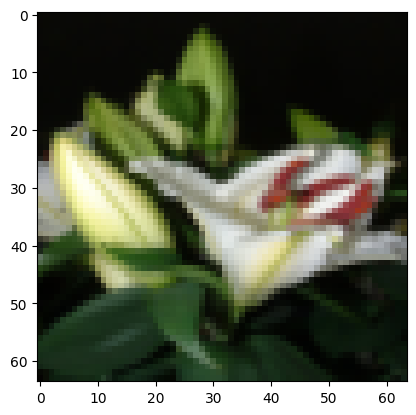

In [39]:
# Example of a picture
index = 4
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

**Важливо**: багато помилок у глибокому навчанні виникають через невідповідність розмірностей матриць/векторів. Якщо ви будете чітко контролювати розмірності, це значно зменшить кількість помилок.

<a name='ex-1'></a>
### Вправа 1
Знайдіть значення для:
- m_train (кількість тренувальних прикладів)
- m_test (кількість тестових прикладів)
- num_px (висота = ширина тренувального зображення у пікселях)

Пам'ятайте, що `train_set_x_orig` є numpy-масивом форми `(m_train, num_px, num_px, 3)`. Наприклад, ви можете отримати `m_train` через `train_set_x_orig.shape[0]`.

**Примітка перекладача**:
- "shape" у контексті NumPy залишається без перекладу, оскільки це технічний термін
- "numpy-array" також залишається без перекладу, оскільки це власна назва структури даних
- Індекс "[0]" залишається у оригінальному форматі, оскільки це частина синтаксису Python

In [40]:
# код аналізує базову статистику датасету перед початком роботи з моделлю.

m_train = train_set_x_orig.shape[0]  # Отримуємо кількість тренувальних зображень (прикладів) з першого виміру масиву train_set_x_orig
m_test = test_set_x_orig.shape[0]    # Отримуємо кількість тестових зображень   
num_px = train_set_x_orig.shape[1]   # Отримуємо розмірність зображення (висоту/ширину) з другого виміру train_set_x_orig

# CODE_START
# CODE_END

print ("кількість тренувальних прикладів: m_train = " + str(m_train))
print ("кількість тестових прикладів: m_test = " + str(m_test))
print ("розмірність (висоту/ширину) кожного зображення: num_px = " + str(num_px))

print ("кожне зображення має розмір: (" + str(num_px) + ", " + str(num_px) + ", 3)")

# Виводимо розмірність навчального набору зображень
print ("train_set_x shape: " + str(train_set_x_orig.shape))
# Виводимо розмірність міток навчального набору
print ("train_set_y shape: " + str(train_set_y.shape))
# Виводимо розмірність тестового набору зображень
print ("test_set_x shape: " + str(test_set_x_orig.shape))
# Виводимо розмірність міток тестового набору
print ("test_set_y shape: " + str(test_set_y.shape))


кількість тренувальних прикладів: m_train = 209
кількість тестових прикладів: m_test = 50
розмірність (висоту/ширину) кожного зображення: num_px = 64
кожне зображення має розмір: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Expected Output for m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td> m_train </td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>m_test</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>num_px</td>
    <td> 64 </td> 
  </tr>
  
</table>


Для зручності вам слід перетворити зображення розміром (num_px, num_px, 3) у numpy-масив форми (num_px * num_px * 3, 1). Після цього наш тренувальний (і тестовий) набір даних стане numpy-масивом, де кожен стовпець представлятиме розгорнуте зображення. Має бути m_train (відповідно m_test) стовпців.

<a name='ex-2'></a>
### Вправа 2
Перетворіть тренувальний та тестовий набори даних так, щоб зображення розміром (num_px, num_px, 3) стали векторами форми (num_px * num_px * 3, 1).

Якщо у вас є матриця X форми (a, b, c, d), то щоб її перетворити у форму (b * c * d, a), можна зробити так:
```python    
X_flatten = X.reshape(X.shape[0], -1).T      # X.T - це транспонована матриця X
```

In [41]:

# Переформовуємо тренувальні зображення у вектори розміром (num_px*num_px*3, m_train)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
# Переформовуємо тестові зображення у вектори розміром (num_px*num_px*3, m_test)
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T


# Перевірка: порівнюємо перші 10 пікселів другого тренувального зображення з очікуваними значеннями
assert np.alltrue(train_set_x_flatten[0:10, 1] == [196, 192, 190, 193, 186, 182, 188, 179, 174, 213]), "Wrong solution. Use (X.shape[0], -1).T."
# Перевірка: порівнюємо перші 10 пікселів другого тестового зображення з очікуваними значеннями
assert np.alltrue(test_set_x_flatten[0:10, 1] == [115, 110, 111, 137, 129, 129, 155, 146, 145, 159]), "Wrong solution. Use (X.shape[0], -1).T."

# Виводимо розміри отриманих векторів тренувальних зображень, міток тренувального набору,векторів тестових зображень,розміри міток тестового набору
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


**Expected Output**: 

<table style="width:35%">
  <tr>
    <td>train_set_x_flatten shape</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>train_set_y shape</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>test_set_x_flatten shape</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>test_set_y shape</td>
    <td>(1, 50)</td> 
  </tr>
</table>

Для представлення кольорових зображень необхідно вказати червоний, зелений та синій канали (RGB) для кожного пікселя, тому значення пікселя насправді є вектором із трьох чисел у діапазоні від 0 до 255.

Одним із поширених етапів попередньої обробки даних у машинному навчанні є центрування та стандартизація набору даних. Це означає, що від кожного прикладу віднімається середнє значення всього масиву numpy, а потім кожен приклад ділиться на стандартне відхилення всього масиву numpy. Однак для наборів даних із зображеннями простіше та зручніше (і це працює майже так само добре) просто поділити кожен рядок набору даних на 255 (максимальне значення каналу пікселя).

Давайте стандартизуємо наш набір даних.

In [42]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

**Загальні кроки для попередньої обробки нового набору даних**:

- Визначити розмірності та форми даних (m_train, m_test, num_px, ...)
- Перетворити набори даних так, щоб кожен приклад став вектором розміру (num_px * num_px * 3, 1)
- Стандартизувати дані

<a name='3'></a>
## 3 - General Architecture of the learning algorithm ##

## 3 - Загальна архітектура алгоритму навчання ##

Настав час розробити простий алгоритм для розрізнення зображень котів та інших об'єктів.

Ви побудуєте Логістичну регресію, використовуючи підхід Нейронних мереж. Наступний рисунок пояснює, чому **Логістична регресія насправді є дуже простою Нейронною мережею!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Математичний вираз алгоритму**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

Вартість обчислюється шляхом підсумовування по всіх навчальних прикладах:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Ключові кроки**:
У цій вправі ви виконаєте наступні дії:

- Ініціалізуєте параметри моделі
- Вивчите параметри моделі шляхом мінімізації вартості
- Використаєте вивчені параметри для прогнозування (на тестовому наборі)
- Проаналізуєте результати та зробите висновки


<a name='4'></a>
## 4 - Побудова компонентів нашого алгоритму ##

Основні кроки для побудови нейронної мережі:
1. Визначити структуру моделі (наприклад, кількість вхідних ознак)
2. Ініціалізувати параметри моделі
3. Цикл:
    - Обчислити поточні втрати (пряме поширення)
    - Обчислити поточний градієнт (зворотне поширення)
    - Оновити параметри (градієнтний спуск)

Зазвичай компоненти 1-3 будуються окремо та інтегруються в одну функцію, яку ми називаємо `model()`.

You often build 1-3 separately and integrate them into one function we call `model()`.

<a name='4-1'></a>
### 4.1 - Helper functions

<a name='ex-3'></a>
### Exercise 3 - sigmoid
Спочатку реалізуйте функцію `sigmoid()`. Як ви бачили на рисунку вище, необхідно обчислити
$$
sigmoid(z) = \frac{1}{1 + e^{-z}}
$$
for $z = w^T x + b$ щоб робити прогнози. Використовуйте `np.exp()`.



In [43]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    #(≈ 1 line of code)
    s = 1 / (1 + np.exp(-z))
    
    return s

In [44]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid_test(sigmoid)

sigmoid([0, 2]) = [0.5        0.88079708]
All tests passed!


In [45]:
x = np.array([0.5, 0, 2.0])
output = sigmoid(x)
print(output)

[0.62245933 0.5        0.88079708]


<a name='4-2'></a>
### 4.2 - Ініціалізація параметрів

<a name='ex-4'></a>
### Exercise 4 - initialize_with_zeros
Реалізуйте ініціалізацію параметрів у клітинці нижче. Вам потрібно ініціалізувати w як вектор нулів. Якщо ви не знаєте, яку функцію NumPy використати, зверніться до документації бібліотеки Numpy за функцією `np.zeros()`.

In [46]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    Ця функція створює вектор нулів розміру (dim, 1) для w та ініціалізує b як 0.

    Аргументи:
    dim -- розмір вектора w, який ми хочемо отримати (або кількість параметрів у цьому випадку)

    Повертає:
    w -- ініціалізований вектор розміру (dim, 1)
    b -- ініціалізований скаляр (відповідає зміщенню) типу float
    """

    
    # (≈ 2 lines of code)
    w = np.zeros((dim, 1))
    b = 0.0

    return w, b

In [47]:
dim = 2
w, b = initialize_with_zeros(dim)

assert type(b) == float
print ("w = " + str(w))
print ("b = " + str(b))

initialize_with_zeros_test_1(initialize_with_zeros)
initialize_with_zeros_test_2(initialize_with_zeros)


w = [[0.]
 [0.]]
b = 0.0
First test passed!
Second test passed!


<a name='4-3'></a>
### 4.3 - Пряме та зворотнє поширення

Тепер, коли ваші параметри ініціалізовані, ви можете виконувати кроки "прямого" та "зворотного" поширення для навчання параметрів.

<a name='ex-5'></a>
### Вправа 5 - propagate
Реалізуйте функцію `propagate()`, яка обчислює функцію вартості та її градієнт.

**Hints**:

Пряме поширення:
- Ви отримуєте X
- Обчислюєте $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Розраховуєте функцію вартості: $J = -\frac{1}{m}\sum\limits_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

Ось дві формули, які ви будете використовувати:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$



In [48]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Реалізуйте функцію вартості та її градієнт для описаного вище поширення

    Аргументи:
    w -- ваги, numpy масив розміру (num_px * num_px * 3, 1)
    b -- зміщення, скаляр
    X -- дані розміру (num_px * num_px * 3, кількість прикладів)
    Y -- вектор "справжніх" міток (містить 0 для не-кішок, 1 для кішок) розміру (1, кількість прикладів)

    Повертає:
    grads -- словник, що містить градієнти ваг та зміщення
    (dw -- градієнт втрат відносно w, має таку ж форму як w)
    (db -- градієнт втрат відносно b, має таку ж форму як b)
    cost -- вартість негативного логарифмічного правдоподібня для логістичної регресії

Поради:

    Напишіть код крок за кроком для поширення. Використовуйте np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    # compute activation
    Z = np.dot(w.T, X) + b
    A = 1 / (1 + np.exp(-Z))
    # compute cost by using np.dot to perform multiplication. 
    # And don't use loops for the sum.
    cost = -1/m * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))                              


    # BACKWARD PROPAGATION (TO FIND GRAD)
    dZ = A - Y
    dw = 1/m * np.dot(X, dZ.T)
    db = 1/m * np.sum(dZ)

    cost = np.squeeze(np.array(cost))

    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [49]:
w =  np.array([[1.], [2]])
b = 1.5

# X is using 3 examples, with 2 features each
# Each example is stacked column-wise
X = np.array([[1., -2., -1.], [3., 0.5, -3.2]])
Y = np.array([[1, 1, 0]])
grads, cost = propagate(w, b, X, Y)

assert type(grads["dw"]) == np.ndarray
assert grads["dw"].shape == (2, 1)
assert type(grads["db"]) == np.float64


print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

propagate_test(propagate)

dw = [[ 0.25071532]
 [-0.06604096]]
db = -0.1250040450043965
cost = 0.15900537707692405
All tests passed!


**Expected output**

```
dw = [[ 0.25071532]
 [-0.06604096]]
db = -0.1250040450043965
cost = 0.15900537707692405
```

<a name='4-4'></a>
### 4.4 - Оптимізація
- Ви ініціалізували свої параметри.
- Ви також можете обчислити функцію вартості та її градієнт.
- Тепер ви хочете оновити параметри, використовуючи градієнтний спуск.

<a name='ex-6'></a>
### Вправа 6 - optimize
Напишіть функцію оптимізації. Мета - навчити $w$ та $b$, мінімізуючи функцію вартості $J$. Для параметра $\theta$ правило оновлення: $\theta = \theta - \alpha \text{ } d\theta$, де $\alpha$ - швидкість навчання.

In [50]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    Ця функція оптимізує w та b, виконуючи алгоритм градієнтного спуску

    Аргументи:
        w -- ваги, numpy масив розміру (num_px * num_px * 3, 1)
        b -- зміщення, скаляр
        X -- дані розміру (num_px * num_px * 3, кількість прикладів)
        Y -- вектор "справжніх" міток (0 - не кіт, 1 - кіт), розміру (1, кількість прикладів)
        num_iterations -- кількість ітерацій циклу оптимізації
        learning_rate -- швидкість навчання для правила оновлення градієнтного спуску
        print_cost -- True для виведення втрат кожні 100 кроків

    Повертає:
        params -- словник, що містить ваги w та зміщення b
        grads -- словник, що містить градієнти ваг та зміщення відносно функції вартості
        costs -- список усіх обчислених значень вартості під час оптимізації (для побудови кривої навчання)

    Поради:
    Вам потрібно реалізувати два кроки та ітерувати через них:
        1) Обчислити вартість та градієнт для поточних параметрів (використати propagate())
        2) Оновити параметри за допомогою правила градієнтного спуску для w та b
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        # (≈ 1 lines of code)
        # Cost and gradient calculation 
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [51]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print("Costs = " + str(costs))

optimize_test(optimize)

w = [[0.80956046]
 [2.0508202 ]]
b = 1.5948713189708588
dw = [[ 0.17860505]
 [-0.04840656]]
db = -0.08888460336847771
Costs = [array(0.15900538)]
All tests passed!


<a name='ex-7'></a>
### Вправа 7 - predict
Попередня функція повертає навчені параметри w та b. Ми можемо використовувати w і b для передбачення міток набору даних X. Реалізуйте функцію `predict()`. Є два кроки для обчислення передбачень:

1. Обчисліть $\hat{Y} = A = \sigma(w^T X + b)$

2. Перетворіть значення a у 0 (якщо активація <= 0.5) або 1 (якщо активація > 0.5), зберігаючи передбачення у векторі `Y_prediction`. За бажанням, можете використати `if`/`else` у циклі `for` (хоча існує спосіб векторизувати цю операцію).


In [52]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Прогнозує, чи є мітка 0 чи 1, використовуючи навчені параметри логістичної регресії (w, b)

    Аргументи:
    w -- ваги, numpy масив розміру (num_px * num_px * 3, 1)
    b -- зміщення, скаляр
    X -- дані розміру (num_px * num_px * 3, кількість прикладів)

    Повертає:
    Y_prediction -- numpy масив (вектор), що містить усі прогнози (0/1) для прикладів у X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Обчислюємо вектор "A", що прогнозує ймовірності наявності кота на зображенні
    #(≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    
    # CODE_START
    
    # Векторизована реалізація (рекомендовано)
    Y_prediction = (A > 0.5).astype(int)
    

    for i in range(A.shape[1]):
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        #(≈ 4 lines of code)
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
        pass
    
    return Y_prediction

In [53]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2],[1.2, 2., 0.1]])
print ("predictions = " + str(predict(w, b, X)))

predict_test(predict)

predictions = [[1 1 0]]
All tests passed!


Ви реалізували кілька ключових функцій, які:

1. Ініціалізують параметри (w, b)
2. Оптимізують функцію втрат для навчання параметрів (w, b):
   - Обчислюють вартість та її градієнт
   - Оновлюють параметри за допомогою градієнтного спуску
3. Використовують навчені параметри (w, b) для прогнозування міток на заданому наборі прикладів

Ці функції формують повний конвеєр логістичної регресії, реалізованої з використанням підходу нейронних мереж. Кожен етап є важливою складовою процесу машинного навчання.

<a name='5'></a>
## 5 - Об'єднання всіх функцій у модель ##

Тепер ви побачите, як структурована загальна модель, об'єднавши всі складові елементи (функції, реалізовані в попередніх частинах) у правильному порядку.

<a name='ex-8'></a>
### Вправа 8 - model
Реалізуйте функцію model. Використовуйте наступні позначення:
- `Y_prediction_test` для ваших прогнозів на тестовому наборі
- `Y_prediction_train` для ваших прогнозів на навчальному наборі
- `parameters`, `grads`, `costs` для виводу функції optimize()

In [54]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Побудова моделі логістичної регресії шляхом виклику раніше реалізованих функцій

    Аргументи:
        X_train -- навчальний набір у вигляді numpy масиву розміру (num_px * num_px * 3, m_train)
        Y_train -- навчальні мітки у вигляді numpy масиву (вектора) розміру (1, m_train)
        X_test -- тестовий набір у вигляді numpy масиву розміру (num_px * num_px * 3, m_test)
        Y_test -- тестові мітки у вигляді numpy масиву (вектора) розміру (1, m_test)
        num_iterations -- гіперпараметр, що визначає кількість ітерацій оптимізації
        learning_rate -- гіперпараметр, що визначає швидкість навчання для optimize()
        print_cost -- Якщо True, виводить значення функції втрат кожні 100 ітерацій

    Повертає:
        d -- словник з інформацією про модель
    """
    # Ініціалізація параметрів нулями
    # and use the "shape" function to get the first dimension of X_train
    w, b = initialize_with_zeros(X_train.shape[0])
    
    # Градієнтний спуск
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Отримання параметрів w та b зі словника params
    w = params["w"]
    b = params["b"]
    
    # Прогнозування для тестового/навчального наборів
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    

    # Print train/test Errors
    if print_cost:
        print("Точність на навчальному наборі: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [55]:
from public_tests import *

model_test(model)

All tests passed!


If you pass all the tests, run the following cell to train your model.

In [56]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
Точність на навчальному наборі: 99.04306220095694 %
test accuracy: 70.0 %


**Коментар**:

* Точність на тренувальних даних близька до 100%. Це гарна перевірка здорового глузду: ваша модель працює і має достатню ємність, щоб запам’ятати тренувальні дані.
* Точність на тестових даних — 70%. Насправді це непогано для такої простої моделі, з огляду на невеликий обсяг даних і те, що логістична регресія є лінійним класифікатором.

Також видно, що модель явно перенавчається на тренувальних даних.

Використовуючи наведений нижче код (і змінюючи змінну `index`), ви можете переглядати передбачення для зображень із тестового набору.



y = 1, you predicted that it is a "cat" picture.


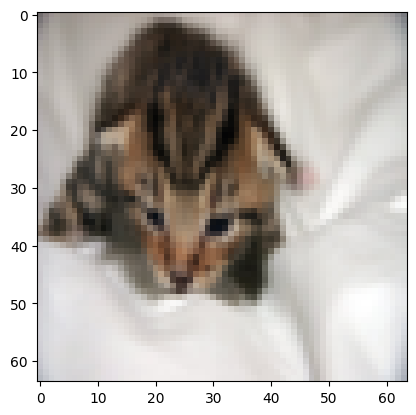

In [78]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

Let's also plot the cost function and the gradients.

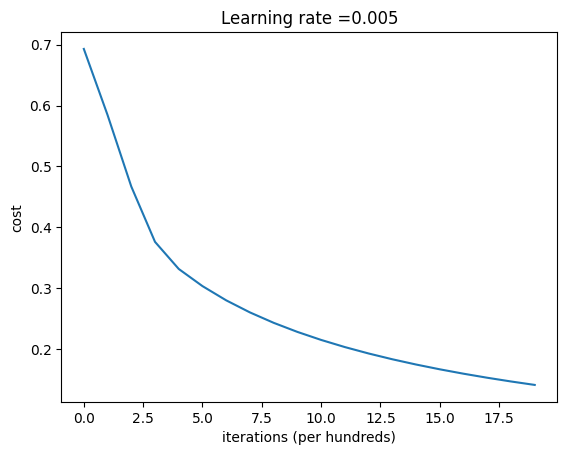

In [28]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

**Інтерпретація**:
Ви можете бачити, що вартість (cost) зменшується. Це свідчить про те, що параметри навчаються. Проте видно, що модель ще можна було б додатково натренувати на тренувальному наборі. Спробуйте збільшити кількість ітерацій у клітинці вище та перезапустити клітинки. Ви можете побачити, що точність на тренувальному наборі зросте, але точність на тестовому — знизиться. Це називається **перенавчанням**.


<a name='6'></a>

## 6 – Подальший аналіз

Вітаємо з побудовою вашої першої моделі для класифікації зображень. Давайте проаналізуємо її глибше та розглянемо можливі варіанти вибору коефіцієнта навчання 



#### Вибір коефіцієнта навчання

**Нагадування**:
Щоб градієнтний спуск працював коректно, потрібно правильно вибрати коефіцієнт навчання. Коефіцієнт навчання \$\alpha\$ визначає, наскільки швидко ми оновлюємо параметри. Якщо він занадто великий, ми можемо «перестрибнути» оптимальне значення. Якщо ж занадто малий — знадобиться дуже багато ітерацій, щоб збігтись до найкращих значень. Тому надзвичайно важливо використовувати добре підібраний коефіцієнт навчання.

Давайте порівняємо графіки навчання нашої моделі при кількох значеннях коефіцієнта навчання. Запустіть клітинку нижче — це має зайняти приблизно 1 хвилину. Також ви можете спробувати інші значення, окрім тих трьох, які вже встановлені у змінній `learning_rates`, і подивитися, що вийде.



Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



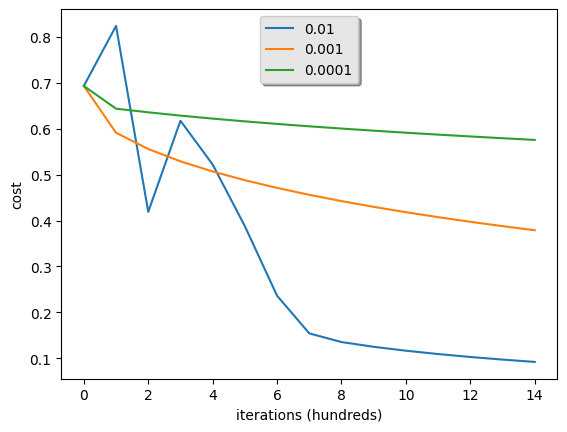

In [29]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Інтерпретація**:

* Різні коефіцієнти навчання дають різні значення функції втрат і, відповідно, різні результати передбачення.
* Якщо коефіцієнт навчання занадто великий (наприклад, 0.01), функція втрат може коливатися вгору-вниз. Вона навіть може розійтися (хоча в цьому прикладі, використовуючи 0.01, вартість зрештою сходиться до хорошого значення).
* Нижча вартість (cost) не завжди означає кращу модель. Потрібно перевіряти, чи немає перенавчання. Це відбувається, коли точність на тренувальних даних значно вища, ніж на тестових.
* У глибокому навчанні зазвичай рекомендується:

  * Вибирати такий коефіцієнт навчання, який краще мінімізує функцію втрат.
  * Якщо ваша модель перенавчається, використовуйте інші техніки для зменшення перенавчання. (Ми поговоримо про це в наступних відео.)


<a name='7'></a>

## 7 – Перевірка на власному зображенні

Вітаємо із завершенням цього завдання! Тепер ви можете використати власне зображення й подивитися, як ваша модель спрацює. Щоб це зробити:

1. Додайте ваше зображення до каталогу цього Jupyter Notebook, у папку “images”
2. Змініть назву зображення у відповідному рядку коду
3. Запустіть код і перевірте, чи алгоритм правильно класифікує зображення (1 = кіт, 0 = не кіт)


y = 0, your algorithm predicts a "non-cat" picture.


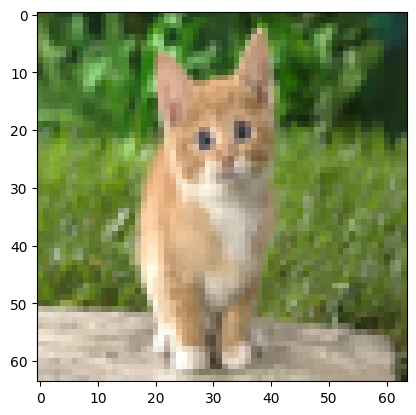

In [81]:
# change this to the name of your image file
my_image = "Cats-image-cats-36712791-1222-917.jpg"   

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

**Важливо:**

1. Попередня обробка датасету має велике значення.
2. Ви реалізували кожну функцію окремо: `initialize()`, `propagate()`, `optimize()`. Потім ви побудували повну модель за допомогою `model()`.
3. Налаштування коефіцієнта навчання (який є прикладом «гіперпараметра») може суттєво вплинути на ефективність алгоритму. У наступних частинах курсу ви побачите ще більше прикладів цього!

Наостанок, якщо хочете, ми запрошуємо вас поекспериментувати з цим ноутбуком. Обов’язково надішліть свою роботу перед тим, як почнете щось змінювати. Після відправки ви можете спробувати таке:

* Пограйтеся з коефіцієнтом навчання та кількістю ітерацій
* Спробуйте різні методи ініціалізації параметрів і порівняйте результати
* Перевірте інші способи попередньої обробки даних (наприклад, центроване масштабування або поділ кожного рядка на його стандартне відхилення)


**Recommended reading**:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c